# FitzHugh-Nagumoモデル
## FitzHugh-Nagumoモデルの定義

前節では神経活動のダイナミクスを微分方程式で表したHodgkin-Huxley(HH)モデルを扱った．HHモデルの特徴は，4変数で構成され，各変数が膜電位およびNaチャネルやKチャネルなどの活性/不活性状態を意味することである．このHHモデルをより簡易化し，2変数で神経活動の興奮とその伝播を表そうと提案されたのが**FitzHugh-Nagumo (FHN)モデル** である．FHNモデルはvan der Pol振動子をFitzHughが修正し{cite:p}`FitzHugh1955-bx` {cite:p}`Fitzhugh1961-fp`，南雲らによりトンネル (江崎) ダイオードを用いて電子回路上に実装\footnote{神経活動を再現する電子回路を**ニューリスタ** （neuristor）という．}された {cite:p}`Nagumo1962-ob`という経緯がある．FHNモデルは以下で表される．

$$
\begin{align} 
\frac{dv}{dt} &= c\left(v-\frac{v^3}{3}-u+I_e\right)\\ 
\frac{du}{dt} &= v-bu+a 
\end{align}
$$

$v$は膜電位で，$u$は回復変数(recovery variable)と呼ばれる． FitzHughにより，HHモデルにおける$(V, m)$および$(n, h)$がそれぞれFHNモデルの$v$および$u$に対応すると説明されている {cite:p}`Fitzhugh1961-fp` \footnote{HHモデルにおける$V$と$m$は強い正の相関があり，$n$と$h$は強い負の相関があるため，それぞれの変数の組は1つの変数に縮約されうる．}．$a,b,c$は定数であり，$a=0.7, b=0.8, c=10$がよく使われる．$I_e$は外部刺激電流に対応する．

In [1]:
using Parameters: @unpack # or using UnPack
using PyPlot
rc("axes.spines", top=false, right=false)

変更しない定数を保持する `struct` の `FHNParameter` と, 変数を保持する `mutable struct` の `FHN` を作成する．

In [2]:
abstract type Layer end
abstract type Neuron <: Layer end

@kwdef struct FHNParameter{FT}
    a::FT = 0.7; b::FT = 0.8; c::FT = 10.0
end

@kwdef mutable struct FHN{FT} <:Neuron
    num_neurons::UInt16
    dt::FT = 1e-2
    param::FHNParameter = FHNParameter{FT}()
    v::Vector{FT} = fill(-1.0, num_neurons) 
    u::Vector{FT} = zeros(num_neurons)
end

次に変数を更新する関数`update!`を書く．ソルバーとしては陽的Euler法または4次のRunge-Kutta法を用いる．以下ではEuler法を用いている．Juliaではforループを用いて1つのニューロンごとにパラメータを更新する方がベクトルを用いるよりも高速である．

In [3]:
function update!(neuron::FHN, x::Vector)
    @unpack num_neurons, dt, v, u = neuron
    @unpack a, b, c = neuron.param
    @inbounds for i = 1:num_neurons
        v[i] += dt * c * (-u[i] + v[i] - v[i]^3 / 3 + x[i])
        u[i] += dt * (v[i] - b*u[i] + a)
    end
    return v
end

(layer::Layer)(x) = update!(layer, x)

## FitzHugh-Nagumoモデルのシミュレーションの実行
いくつかの定数を設定してシミュレーションを実行する．

In [4]:
T = 100 # ms
dt = 0.01 # ms
nt = UInt32(T/dt) # number of timesteps
num_neurons = 1 # ニューロンの数

# 入力刺激
time = (1:nt)*dt
Ie = repeat(0.5 * ((time .> 10) - (time .> 45)) + 0.34 * ((time .> 55) - (time .> 90)), 1, num_neurons)  # injection current

# 記録用
varr, uarr = zeros(Float32, nt, num_neurons), zeros(Float32, nt, num_neurons)

# modelの定義
fhn_neurons = FHN{Float32}(num_neurons=num_neurons, dt=dt)

# simulation
@time for t = 1:nt
    v = fhn_neurons(Ie[t, :])
    varr[t, :], uarr[t, :] = v, fhn_neurons.u
end

  0.107937 seconds (423.02 k allocations: 13.061 MiB, 89.77% compilation time)


結果を描画する．

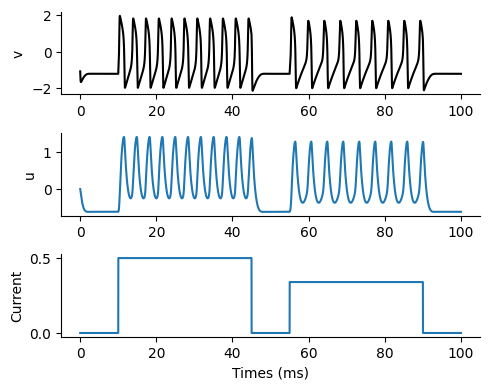

In [5]:
figure(figsize=(5,4))
subplot(3, 1, 1); plot(time, varr[:, 1], label=false, color="black"); ylabel("v")
subplot(3, 1, 2); plot(time, uarr[:, 1], label=false); ylabel("u"); 
subplot(3, 1, 3); plot(time, Ie, label=false); ylabel("Current"); xlabel("Times (ms)")
tight_layout()

## 相図の描画
phase plot

In [7]:
margin = 1.0
vmax, vmin = maximum(varr) + margin, minimum(varr) - margin
umax, umin = maximum(uarr) + margin, minimum(uarr) - margin
vrange, urange = vmin:0.1:vmax, umin:0.1:umax
U = [i for i in urange, j in 1:length(vrange)]
V = [j for i in 1:length(urange), j in vrange]

a, b, c, Ie = 0.7, 0.8, 10.0, 0.34
dV = c * (-U + V - V .^3 / 3 .+ Ie)
dU = V - b*U .+ a;

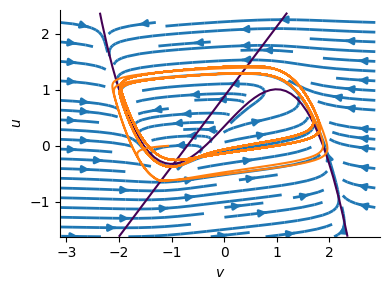

In [8]:
figure(figsize=(4,3))
streamplot(V, U, dV, dU, density=[0.8, 0.8], linewidth=2) 
contour(V, U, dU, levels=[0])
contour(V, U, dV, levels=[0])
    plot(varr, uarr); xlim(vmin, vmax); ylim(umin, umax); xlabel(L"$v$"); ylabel(L"$u$")
tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```